<a href="https://colab.research.google.com/github/alexferrero23/twitter-category-nlp/blob/develop/src/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import glob
import re
import io

#### Select your file

In [2]:
from google.colab import files
uploaded = files.upload()

Saving working_df (1).orc to working_df (1).orc


In [3]:
import pyarrow.orc 

df_original = pd.read_orc('working_df (1).orc')

In [4]:
df_original.head(5)

,username,created_at,text,lang,label,retweet_count,favorite_count,length
0,RepAdams,2022-04-30 14:42:28,Today my thoughts are with the entire UNC Char...,en,D,3.0,17.0,263
1,RepAdams,2022-04-29 16:40:17,Welcome to the next President of DavidsonColle...,en,D,1.0,0.0,62
2,RepAdams,2022-04-29 01:52:24,"This WorkersMemorialDay, we remember countless...",en,D,2.0,3.0,262
3,RepAdams,2022-04-25 15:38:45,It’s a perfect date to celebrate the 40th Anni...,en,D,3.0,29.0,163
4,RepAdams,2022-04-22 19:57:41,Happy National Volunteer Week! Volunteers mak...,en,D,2.0,6.0,182


#### We are going to use a subset of the dataframe for two reasons: First, models take too much time to fit (unless you are using a huge and expensive machine, which is not my case) and secondly, it seems that more data doesn't lead to better results. At the end of this notebook there will be a more accurate explanation of this.



In [11]:
from sklearn.utils import shuffle
df_d = shuffle(df_original[df_original['label']=='D'])[:10000]
df_r = shuffle(df_original[df_original['label']=='R'])[:10000]
df = df_d.append(df_r, ignore_index=True)

#### Let's create a column with a list of words from tweets

In [12]:
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
nltk.download('stopwords')
stop=list(stopwords.words('english'))
import string
stop.extend(('&amp;', '-', '…', '’', '“', '—', '”', 'amp'))

def create_corpus_column(tweet):
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    cleaned_corpus = []
    corpus = tokenizer.tokenize(tweet)
    for word in corpus:
        if (word not in stop) and (word not in string.punctuation):
             cleaned_corpus.append(word)
    return cleaned_corpus

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [13]:
df['text_corpus'] = df['text'].apply(create_corpus_column)

In [8]:
df.head(5)

,username,created_at,text,lang,label,retweet_count,favorite_count,length,text_corpus
0,SenatorLujan,2020-12-23 01:28:20,Students have been hit hard during the COVID-1...,en,D,9.0,30.0,284,"[students, hit, hard, covid, 19, pandemic, nee..."
1,Nmalliotakis,2022-04-02 12:43:45,I joined ⁦DanNewsManBall⁩ on ⁦OANN⁩ to discuss...,en,D,5.0,30.0,196,"[joined, ⁦, dannewsmanball, ⁩, ⁦, oann, ⁩, dis..."
2,BillPascrell,2022-01-05 19:39:38,Tapping the sign,en,D,179.0,693.0,17,"[tapping, sign]"
3,DonNorcross4NJ,2021-04-16 20:48:21,"By passing the PaycheckFairnessAct, we are tak...",en,D,2.0,2.0,178,"[passing, paycheckfairnessact, taking, major, ..."
4,USRepMikeDoyle,2018-05-18 21:00:38,"Thanks, RepDebDingell , for signing the discha...",en,D,10.0,36.0,82,"[thanks, repdebdingell, signing, discharge, pe..."


#### First of all, I wanna check correlation between the two groups

In [9]:
# Unnest of text_corpus
df_tidy = df.explode(column='text_corpus')
df_tidy = df_tidy.drop(columns='text')
df_tidy.head(3)

,username,created_at,lang,label,retweet_count,favorite_count,length,text_corpus
0,SenatorLujan,2020-12-23 01:28:20,en,D,9.0,30.0,284,students
0,SenatorLujan,2020-12-23 01:28:20,en,D,9.0,30.0,284,hit
0,SenatorLujan,2020-12-23 01:28:20,en,D,9.0,30.0,284,hard


In [10]:
# Data pivot by label
df_pivot = df_tidy.groupby(["label","text_corpus"])["text_corpus"] \
                .agg(["count"]).reset_index() \
                .pivot(index = "text_corpus" , columns="label", values= "count")
df_pivot.columns.name = None

In [11]:
# Consine similarity
from scipy.spatial.distance import cosine

def similitud_coseno(a,b):
    distancia = cosine(a,b)
    return 1-distancia

df_pivot.corr(method=similitud_coseno)

,D,R
D,1.000000,0.909267
R,0.909267,1.000000


#### This is actually really bad news, if there is a big correlation between both groups, its gonna be really difficult to say whether a tweet tends to be republican or democrat


#MODEL
#### For the feature extraction, I'm gonna use Tf-idf (Term frequency – Inverse document frequency) -> Weighing words by how frequent they are in our dataset, discounting words that are too frequent, as they just add to the noise
For model purposes, lets change label from letters to numbers: R -> 0 and D -> 1:


In [14]:
df['label_number'] = df['label'].apply(lambda x: 0 if x == 'R' else 1)

In [15]:
#train-test split
from sklearn.model_selection import train_test_split

datos_X = df.text
datos_y = df.label_number

X_train, X_test, y_train, y_test = train_test_split(
    datos_X,
    datos_y,
    test_size = 0.2,
    random_state = 123
    
)

In [14]:
#check of proportions in both sets
value, counts = np.unique(y_train, return_counts=True)
print(dict(zip(value, 100 * counts / sum(counts))))
value, counts = np.unique(y_test, return_counts=True)
print(dict(zip(value, 100 * counts / sum(counts))))

{0: 49.90625, 1: 50.09375}
{0: 50.375, 1: 49.625}


In [16]:
#Tf-idf matrix
from sklearn.feature_extraction.text import TfidfVectorizer

def tokenize(tweet):
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    corpus = tokenizer.tokenize(tweet)
    return corpus

vectorizer  = TfidfVectorizer(
                        tokenizer  = tokenize,
                        min_df     = 5 #might change
                    )
vectorizer.fit(X_train)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


TfidfVectorizer(min_df=5, tokenizer=<function tokenize at 0x7fc0f1eef560>)

In [16]:
tfidf_train = vectorizer.transform(X_train)
tfidf_test  = vectorizer.transform(X_test)

In [17]:
print(f"Number of tokens created: {len(vectorizer.get_feature_names_out())}");

Number of tokens created: 6699


#### Function to visualize the embeddings in 2 dimensions:

In [18]:
from sklearn.decomposition import TruncatedSVD
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=2, alpha=.8, c=test_labels, cmap=ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Republicans')
            green_patch = mpatches.Patch(color='blue', label='Democrats')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 20})

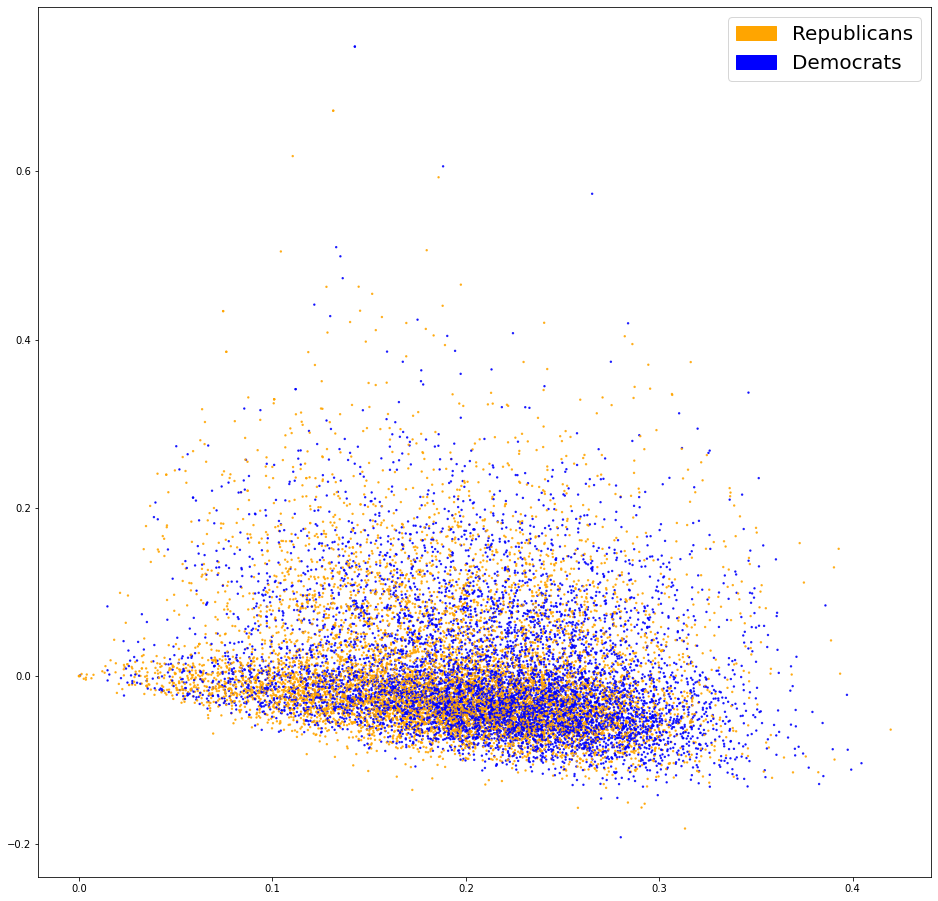

In [19]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(tfidf_train, y_train)
plt.show()

#### Considering the quantity of data we are using, let's say that these embeddings look more or less separated. Now, we check performance with a logistic regression:




In [17]:
%%time

from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
log_reg.fit(tfidf_train, y_train)

y_hat = log_reg.predict(tfidf_test)

NameError: ignored

#### Function to compute accuracy, precision, recall and f1 metrics

In [19]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def get_metrics(y_test, y_hat): 
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_hat)

    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_hat, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_hat, pos_label=None,
                              average='weighted')
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_hat, pos_label=None, average='weighted')
    

    print(f'accuracy = {accuracy}, precision = {precision}, recall = {recall}, f1 = {f1}')

In [24]:
get_metrics(y_test, y_hat)

accuracy = 0.717, precision = 0.7170083206684935, recall = 0.717, f1 = 0.7170025470916953


In [25]:
prop_1s = len(df[df['label_number']==1])/len(df)
print(f'Proportion of 1\'s in label_number in the dataset: {prop_1s}')

Proportion of 1's in label_number in the dataset: 0.5


#### In order to believe the value of the accuracy, per definition, it has to be bigger than the proportion of 1 in label_number in the dataset, which is correct

#### Confusion matrix

In [26]:
from sklearn.metrics import confusion_matrix

def create_confusion_matrix(y_test, y_hat):
  
  conf_matrix = confusion_matrix(y_test, y_hat)
  plt.figure(figsize = (7,5))
  sns.heatmap(conf_matrix, annot=True, fmt='g');


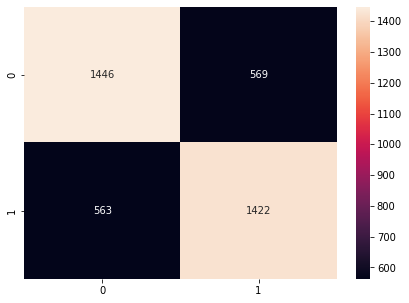

In [27]:
create_confusion_matrix(y_test, y_hat)

#### ROC Curve and area under the ROC Curve

In [28]:
from sklearn.metrics import roc_auc_score, roc_curve

def create_roc_curve(model, y_test, y_train):

  fig = plt.figure(figsize=(10, 10))          

  fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(tfidf_test)[:, 1])
  plt.plot(fpr, tpr, label="Test");

  fpr, tpr, thresholds = roc_curve(y_train, model.predict_proba(tfidf_train)[:, 1])
  plt.plot(fpr, tpr, label="Train");

  plt.legend(loc="lower right", prop={'size': 20});

  print(f'ROC AUC SCORE: {roc_auc_score(y_test, model.predict_proba(tfidf_test)[:, 1])}')


ROC AUC SCORE: 0.7939477845628816


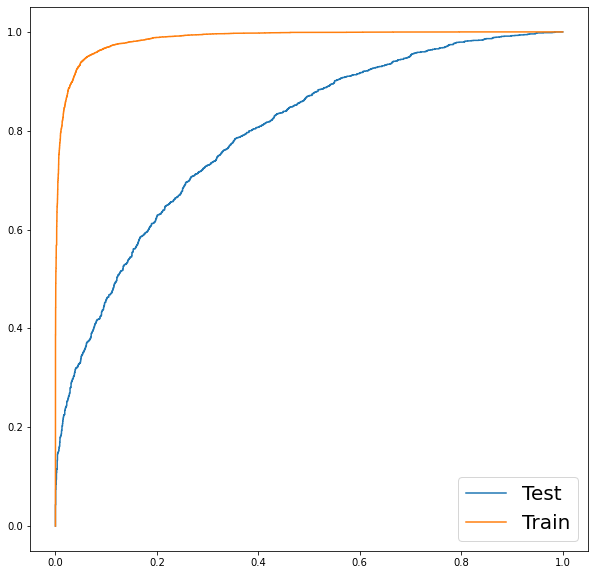

In [29]:
create_roc_curve(log_reg, y_test, y_train)

These are really good results for a first try, but we don't know if they are the best. In order to discover that, I'm going to attemp a grid search for the logistic regression.

In [30]:
param_grid = [{'penalty' : ['l1', 'l2'],
    'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    'solver' : ['liblinear'],
    'max_iter' : [1000]},
    {'penalty' : ['l2'],
    'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    'solver' : ['newton-cg', 'lbfgs'],
    'max_iter' : [1000]}]


In [31]:
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(estimator = LogisticRegression(), param_grid = param_grid, verbose=True, n_jobs=-1)

In [32]:
%%time

best_clf = grid.fit(tfidf_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
CPU times: user 1.14 s, sys: 64 ms, total: 1.2 s
Wall time: 29.5 s


In [33]:
print('Best Score: %s' % best_clf.best_score_)
print('Best Hyperparameters: %s' % best_clf.best_params_)

Best Score: 0.742875
Best Hyperparameters: {'C': 10, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'newton-cg'}


In [34]:
best_model = best_clf.best_estimator_
y_hat = best_model.predict(tfidf_test)

In [35]:
get_metrics(y_test, y_hat)

accuracy = 0.72725, precision = 0.727345629370979, recall = 0.72725, f1 = 0.7272483123584257


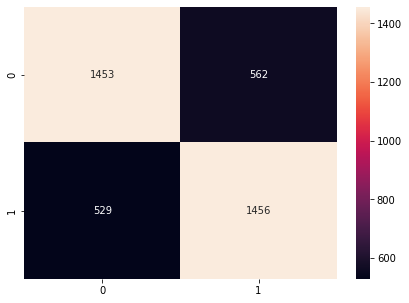

In [36]:
create_confusion_matrix(y_test, y_hat)

ROC AUC SCORE: 0.8137806501615716


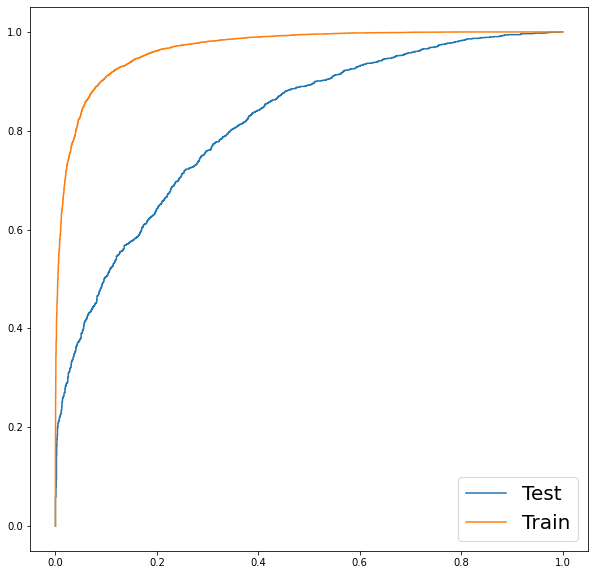

In [37]:
create_roc_curve(best_model, y_test, y_train)

#### Slightly better performance

#### Now let's try a random forest




In [38]:
from sklearn.ensemble import RandomForestClassifier

In [39]:
param_grid = {'bootstrap': [True],
 'max_depth': [None, 1,3,5,10],
 'max_features': ['auto', 'sqrt'],
 'n_estimators': [100]}

In [40]:
grid = GridSearchCV(estimator = RandomForestClassifier(oob_score=True), param_grid = param_grid, verbose=True, n_jobs=-1)

In [41]:
%%time
best_rf_clf = grid.fit(tfidf_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: user 20.4 s, sys: 177 ms, total: 20.6 s
Wall time: 2min 38s


In [42]:
print('Best Score: %s' % best_rf_clf.best_score_)
print('Best Hyperparameters: %s' % best_rf_clf.best_params_)

Best Score: 0.6910624999999999
Best Hyperparameters: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 100}


In [43]:
best_rf = best_rf_clf.best_estimator_
y_hat = best_rf.predict(tfidf_test)

In [45]:
get_metrics(y_test, y_hat)

accuracy = 0.6865, precision = 0.6866216440068761, recall = 0.6865, f1 = 0.6864921624510153


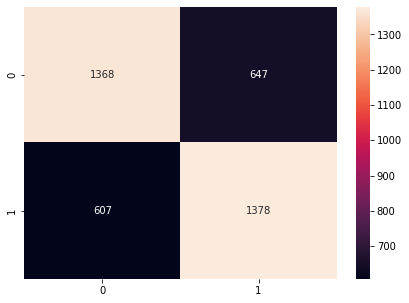

In [46]:
create_confusion_matrix(y_test, y_hat)

ROC AUC SCORE: 0.7579292585207918


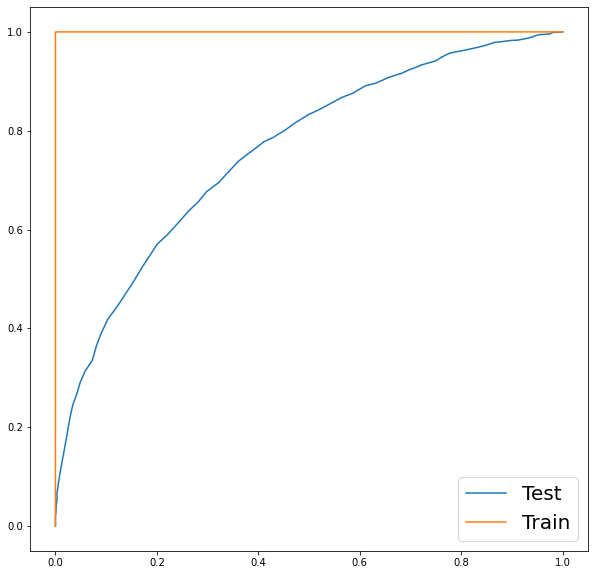

In [47]:
create_roc_curve(best_rf, y_test, y_train)

#### Although we get a slightly worst accuracy than in the logistic regression, random forest are a lot slower and show even more overfitting in the training set than the logistic regression. The logistic regression is the best model so far. But we can try some more.

#### XGBoost

In [48]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(
        learning_rate=0.1,
        max_depth=7,
        n_estimators=80,
        use_label_encoder=False
        )

In [49]:
%%time

xgb_model.fit(tfidf_train, y_train)

CPU times: user 10.6 s, sys: 35.3 ms, total: 10.6 s
Wall time: 10.7 s


XGBClassifier(max_depth=7, n_estimators=80, use_label_encoder=False)

In [50]:
y_hat = xgb_model.predict(tfidf_test)

In [51]:
get_metrics(y_test, y_hat)

accuracy = 0.6825, precision = 0.682822530849103, recall = 0.6825, f1 = 0.6822508248446408


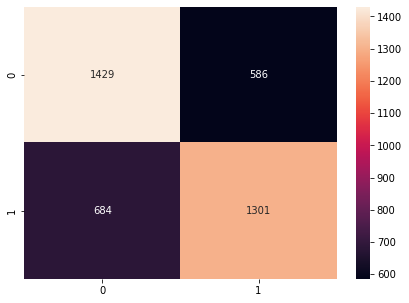

In [52]:
create_confusion_matrix(y_test, y_hat)

ROC AUC SCORE: 0.7533615015844641


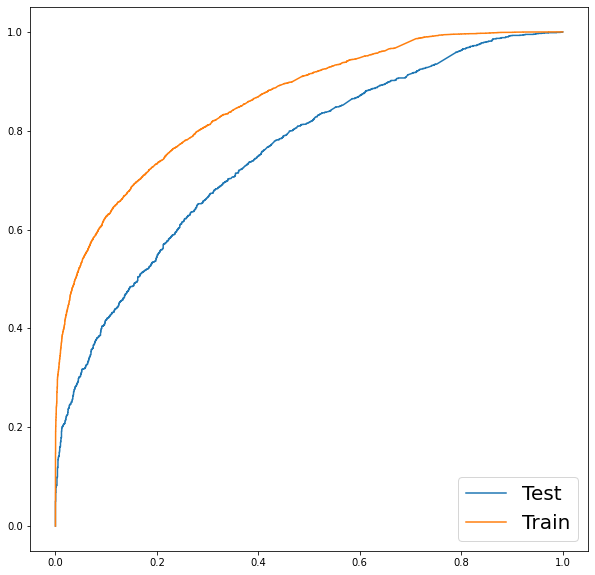

In [53]:
create_roc_curve(xgb_model, y_test, y_train)

#### Let's do a grid search for the XGBoost


In [54]:
param_grid = {
    'max_depth': [1, 3, 5, 10],
    'n_estimators': [10, 20, 40, 80],
    'learning_rate': [0.01, 0.05, 0.1],
    'booster' : ['gbtree']
    }

In [55]:
grid_search_xgb = GridSearchCV(
    estimator=xgb.XGBClassifier(objective= 'binary:logistic',nthread=4,seed=42),
    param_grid=param_grid,
    #scoring = 'roc_auc',
    n_jobs = -1,
    #cv = 10,
    verbose=True
)

In [56]:
%%time

best_xgb_clf = grid_search_xgb.fit(tfidf_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
CPU times: user 31 s, sys: 604 ms, total: 31.6 s
Wall time: 11min 13s


In [57]:
print('Best Score: %s' % best_xgb_clf.best_score_)
print('Best Hyperparameters: %s' % best_xgb_clf.best_params_)

Best Score: 0.6840625
Best Hyperparameters: {'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 80}


In [58]:
best_xgb = best_xgb_clf.best_estimator_
y_hat = best_xgb.predict(tfidf_test)

In [59]:
get_metrics(y_test, y_hat)

accuracy = 0.6895, precision = 0.689610081418182, recall = 0.6895, f1 = 0.6893892481622779


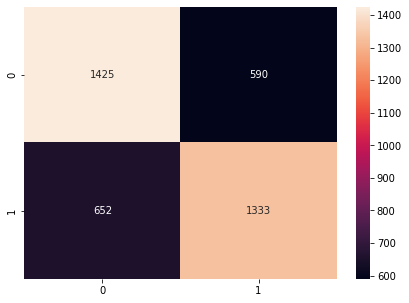

In [60]:
create_confusion_matrix(y_test, y_hat)

ROC AUC SCORE: 0.759694232800595


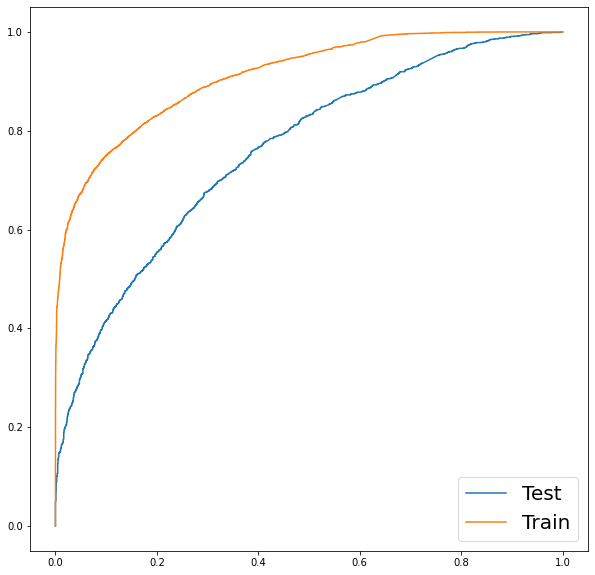

In [61]:
create_roc_curve(best_xgb, y_test, y_train)

#### This model gets an accuracy slighltly lower than logistic regression's, and it's also slower. However, it is the model which shows less overfitting in the training set so far. My conclussion is that we stick with the logistic regression.

#### BERT 

In [154]:
!pip install -q -U tensorflow-text

     |████████████████████████████████| 4.6 MB 28.0 MB/s 
     |████████████████████████████████| 511.7 MB 6.3 kB/s 
     |████████████████████████████████| 438 kB 67.9 MB/s 
     |████████████████████████████████| 1.6 MB 50.2 MB/s 
     |████████████████████████████████| 5.8 MB 20.1 MB/s 


In [155]:
!pip install -q tf-models-official

     |████████████████████████████████| 2.1 MB 13.5 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
     |████████████████████████████████| 1.2 MB 46.6 MB/s 
     |████████████████████████████████| 99 kB 2.2 MB/s 
     |████████████████████████████████| 47.8 MB 48 kB/s 
     |████████████████████████████████| 636 kB 31.7 MB/s 
     |████████████████████████████████| 352 kB 44.9 MB/s 
     |████████████████████████████████| 1.1 MB 37.5 MB/s 
     |████████████████████████████████| 237 kB 47.7 MB/s 
     |████████████████████████████████| 92 kB 7.5 MB/s 


In [182]:
df_shuffled = shuffle(df)

In [183]:
len(df_shuffled)

20000

In [184]:
df_train = df_shuffled[:15999].reset_index()[['text','label_number']]
df_val = df_shuffled[16000:].reset_index()[['text','label_number']]

In [185]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [186]:
from tensorflow.keras.preprocessing.text import Tokenizer

train_text = df_train['text'].to_numpy()

tok = Tokenizer(oov_token='<unk>')
tok.fit_on_texts(train_text)
tok.word_index['<pad>'] = 0
tok.index_word[0] = '<pad>'

train_seqs = tok.texts_to_sequences(train_text)
train_seqs = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

train_labels = df_train['label_number'].to_numpy().flatten()

val_text = df_val['text'].to_numpy()
val_seqs = tok.texts_to_sequences(val_text)
val_seqs = tf.keras.preprocessing.sequence.pad_sequences(val_seqs, padding='post')

val_labels = df_val['label_number'].to_numpy().flatten()

In [187]:
train_ds = tf.data.Dataset.from_tensor_slices((train_seqs, train_labels))
val_ds = tf.data.Dataset.from_tensor_slices((val_seqs, val_labels))

In [188]:
BATCH_SIZE = 32
train_ds_batch = train_ds.batch(BATCH_SIZE)
val_ds_batch = val_ds.batch(BATCH_SIZE)

In [189]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds_batch = train_ds_batch.cache().prefetch(buffer_size=AUTOTUNE)
val_ds_batch = val_ds_batch.cache().prefetch(buffer_size=AUTOTUNE)

In [190]:
from tensorflow import keras
from tensorflow.keras import layers

vocab_size =len(tok.word_index) + 1
embedding_dim = 256

model = keras.Sequential([
    layers.Embedding(vocab_size, embedding_dim),
    layers.GlobalAveragePooling1D(),
    layers.Dense(1, activation='sigmoid') # also tried activation='softmax'
])

model.compile(optimizer='adam',
              loss='binary_crossentropy', # binary_crossentropy
              metrics=['accuracy'])

history = model.fit(
    train_ds_batch,
    epochs=3,
    validation_data=val_ds_batch, validation_steps=1, steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
)

Epoch 1/3
15999/15999 [==============================] - 45s 3ms/step - loss: 0.6385 - accuracy: 0.6349 - val_loss: 0.5749 - val_accuracy: 0.7188


#### So at first glance, BERT model is the one with worst results. 


# PENDING EXPERIMENT SOME TIME WITH THE BERT, IT SHOULD SHOW BETTER RESULTS. ALSO ADD THE PROOF THAT MORE DATA DOESN'T LEAD TO BETTER RESULTS. ALSO ADD FEATURE IMPORTANCE

#### Now, let's see the feature importance of the logistic regression

In [77]:
important_tokens = pd.DataFrame(
    data=best_model.coef_[0],
    index=vectorizer.get_feature_names(),
    columns=['Score']
).sort_values(by='Score' ,ascending=False)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


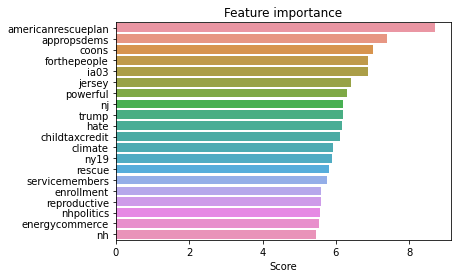

In [79]:
sns.barplot(x=important_tokens[:20]['Score'], y=important_tokens[:20].index).set_title('Feature importance');

#### Why more isn't better

In [5]:
def steps_for_lg(df_original, vectorizer, sample_size):

  print(f'Executing sample_size = {sample_size}')

  df_d = shuffle(df_original[df_original['label']=='D'])[:sample_size]
  df_r = shuffle(df_original[df_original['label']=='R'])[:sample_size]
  df = df_d.append(df_r, ignore_index=True)

  df['text_corpus'] = df['text'].apply(create_corpus_column)

  df['label_number'] = df['label'].apply(lambda x: 0 if x == 'R' else 1)

  datos_X = df.text
  datos_y = df.label_number

  X_train, X_test, y_train, y_test = train_test_split(
      datos_X,
      datos_y,
      test_size = 0.2,
      random_state = 123
  )

  vectorizer.fit(X_train)

  tfidf_train = vectorizer.transform(X_train)
  tfidf_test  = vectorizer.transform(X_test)

  log_reg = LogisticRegression(C=10.0, solver='newton-cg', max_iter=1000)
  log_reg.fit(tfidf_train, y_train)

  y_hat = log_reg.predict(tfidf_test)

  accuracy = accuracy_score(y_test, y_hat)

  return accuracy

In [6]:
sample_size_list = [100, 1000, 2500, 5000, 7500, 10000, 20000, 50000, 75000, 100000, 125000, 150000, 175000, 200000]
df_compute_results = pd.DataFrame(columns=['sample_size', 'accuracy', 'time'])

In [20]:
import time

for sample_size in sample_size_list:
  start_time = time.time()
  accuracy = steps_for_lg(df_original, vectorizer, sample_size)
  finish_time = time.time() - start_time

  df_compute_results = df_compute_results.append({'sample_size': sample_size, 'accuracy': accuracy, 'time': finish_time}, ignore_index = True)

Executing sample_size = 10


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


Executing sample_size = 100


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


Executing sample_size = 1000


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


Executing sample_size = 2500


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


Executing sample_size = 5000


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


Executing sample_size = 7500


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


Executing sample_size = 10000


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


Executing sample_size = 20000


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


Executing sample_size = 50000


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


Executing sample_size = 75000


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


Executing sample_size = 100000


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


Executing sample_size = 125000


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


Executing sample_size = 150000


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


Executing sample_size = 175000


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


Executing sample_size = 200000


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


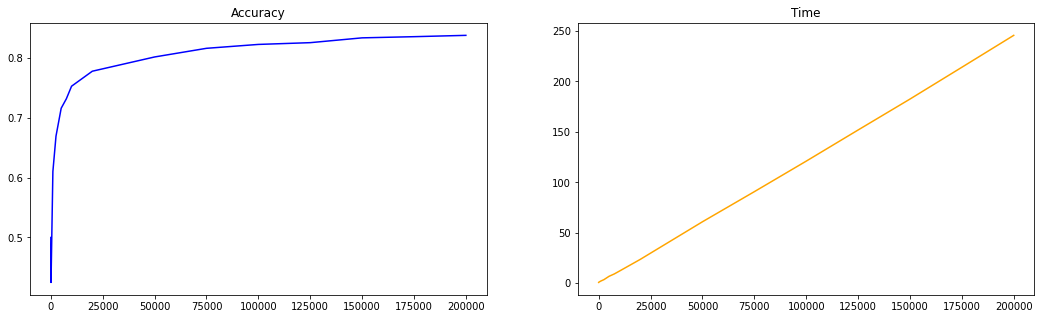

In [31]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(18,5))
ax1.plot(df_compute_results['sample_size'], df_compute_results['accuracy'], color='blue', label='accuracy')
ax1.set_title('Accuracy')
ax2.plot(df_compute_results['sample_size'], df_compute_results['time'], color='orange', label='time')
ax2.set_title('Time')
plt.show()